In [1]:
%pip install huggingface-hub
%pip install numpy
%pip install opencv-python
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import

In [2]:
import os
import json
import re
import time
import math
import numpy as np
import numpy

In [3]:
import cv2
import matplotlib.pyplot as plt

## Config

In [4]:
# secret_hf =

In [5]:
# !huggingface-cli login --token $secret_hf

## Download data

In [6]:
!mkdir dataset

In [7]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="hotamago/Hoc-sau-va-ung-dung-nhom-2", filename="imagedata.zip", revision="main", repo_type="dataset", local_dir="dataset", local_dir_use_symlinks=False)
hf_hub_download(repo_id="hotamago/Hoc-sau-va-ung-dung-nhom-2", filename="label.txt", revision="main", repo_type="dataset", local_dir="dataset", local_dir_use_symlinks=False)

imagedata.zip:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

label.txt:   0%|          | 0.00/53.1k [00:00<?, ?B/s]

'dataset/label.txt'

In [8]:
!sudo apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.2).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


In [9]:
!mkdir datasetImage
!unzip -q -o "dataset/imagedata.zip" -d "datasetImage"

## Load data

In [10]:
prefix_path_data = "/kaggle/working/"

In [11]:
rawlabel = ""

In [12]:
# load label
with open(os.path.join(prefix_path_data, "dataset/label.txt"), "r") as f:
    rawlabel = f.read()
    
# G93aRj07CIZPKaC8.jpg {"label-8":14,"label-7":3,"label-2":4} 16
# name image, label(json), totel people vote
# Format to json {name, label, totel}
labelDataset = []
arrayRawLabel = rawlabel.split("\n")
for ele in arrayRawLabel:
    eleArr = ele.split(" ")
    try:
        labelDataset.append({
            "name": eleArr[0],
            "label": json.loads(eleArr[1]),
            "total": int(eleArr[2])
        })
    except:
        print(ele)

In [13]:
# Label 0 -> 10, 0 is not good image need to delete
def LabelsToVector(labels):
    vectorLabel = [0] * 11
    for label, num in labels.items():
        if len(label.split("-")) != 2:
            print("Error: ", labels)
        vectorLabel[int(label.split("-")[1])] = num
    return vectorLabel

def NormalVectorLabel(vectorLabel, total, presentFilter):
    # Check if label 0 is > presentFilter
    if vectorLabel[0]/total > presentFilter:
        vectorLabel[0] = 1
        for i in range(1, len(vectorLabel)):
            vectorLabel[i] = 0
        return np.array(vectorLabel)
    
    # Process localcation label
    totalLocalVote = 0
    for i in range(1, 3):
        totalLocalVote += vectorLabel[i]
    if totalLocalVote > 0:
        for i in range(1, 3):
            vectorLabel[i] = 1 if vectorLabel[i]/totalLocalVote > presentFilter else 0
    
    # Process orther label
    for i in range(3, len(vectorLabel)):
        vectorLabel[i] = 1 if vectorLabel[i]/total > presentFilter else 0
        
    # Process speacil case
    # Auto set label 1
    goodLabel = [3, 4]
    for i in range(len(goodLabel)):
        if vectorLabel[goodLabel[i]] == 1:
            vectorLabel[1] = 1;
    
    # Auto set label 2
    goodLabel = [7, 8]
    for i in range(len(goodLabel)):
        if vectorLabel[goodLabel[i]] == 1:
            vectorLabel[2] = 1;
            
    # Check if label 1 or 2 is set
    if vectorLabel[1] == vectorLabel[2]:
        vectorLabel[0] = 1
        for i in range(1, len(vectorLabel)):
            vectorLabel[i] = 0
        return np.array(vectorLabel)
#     else:
#         vectorLabel[0] = 0
    
    return np.array(vectorLabel)

In [14]:
# Filter label
for ele in labelDataset:
    # Only get label with > 50% vote
    ele["label"] = NormalVectorLabel(LabelsToVector(ele["label"]), ele["total"], 0.5)
    
# Filter bad image
clearLabelDataset = []
for ele in labelDataset:
    if ele["label"][0] == 0:
        ele["label"] = ele["label"][1:]
        clearLabelDataset.append(ele)
labelDataset = clearLabelDataset

In [15]:
# Add map image name to label
mapImageNameToLabel = {}
for ele in labelDataset:
    mapImageNameToLabel[ele["name"]] = ele["label"]

In [16]:
# Map name for fast filter image
mapNameFastQuery = set()
for ele in labelDataset:
    mapNameFastQuery.add(ele["name"])

In [17]:
# resize image with max(width, height) = size_image_model
def resize_image_reduce_size(image, size_image_model):
    min_size = min(image.shape[0], image.shape[1])
    radio_h = image.shape[0] / min_size
    radio_w = image.shape[1] / min_size
    return cv2.resize(image, (int(radio_w * size_image_model), int(radio_h * size_image_model)))

In [18]:
# Load image
imagesDataset = {}
for label in labelDataset:
    if label["name"] not in mapNameFastQuery:
        continue
    img = resize_image_reduce_size(
        cv2.imread(os.path.join(prefix_path_data, "datasetImage/file", label['name'])),
        224
    )
    imagesDataset[label['name']] = img

## Process

In [19]:
print(len(labelDataset))
print(len(imagesDataset))

770
770


[301 469 143  96  63  50 112  62  45  94]


<BarContainer object of 10 artists>

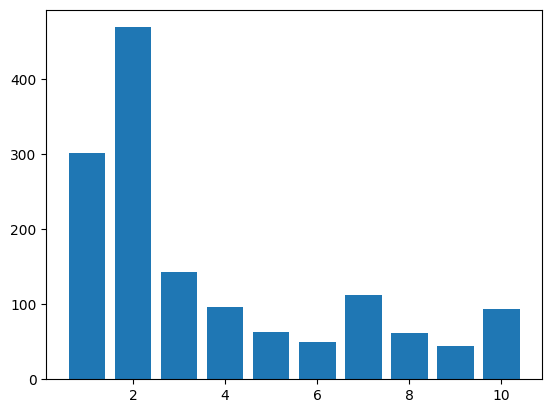

In [20]:
# Plot analytic banlance dataset

totalLabelDataset = np.array([0] * 10)
for ele in labelDataset:
    totalLabelDataset += ele["label"]

print(totalLabelDataset)
    
# Draw
plt.bar([i for i in range(1, 11)], totalLabelDataset)

In [21]:
print(labelDataset[0])

{'name': 'G93aRj07CIZPKaC8.jpg', 'label': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0]), 'total': 17}


In [22]:
csvDataJSON = []
listGoodImage = []
labelValue = ["Hồ Gươm", "Hồ Tây", "Tháp rùa", "Cầu Thê Húc", "Bưu Điện", "Vườn Hoa", "Chùa Trấn Quốc", "Đền Quán Thánh", "Khách Sạn", "Công Viên Nước"]
for ele in labelDataset:
    labelTemp = {}
    for i in range(len(labelValue)):
        labelTemp[labelValue[i]] = ele["label"][i]
    csvDataJSON.append({
        "file": ele["name"],
        **labelTemp
    })
    listGoodImage.append(ele["name"])

In [23]:
# Create csv file
import pandas as pd
pd.DataFrame(csvDataJSON).to_csv("labelData.csv", index=False)

In [24]:
# Create list good 
f = open("listimage.txt", "w")
f.write("\n".join(listGoodImage))
f.close()

In [25]:
# Note:
# imagesDataset is an Dict key is name image, value is image data
# Using: get image data of label name N => imagesDataset[N]
# Get image data of label i => imagesDataset[labelDataset[i]["name"]]

## Preprocess data

### Analytics data

In [26]:
minLabel = np.amin(totalLabelDataset)
print(minLabel)

45


In [27]:
for label in labelDataset:
    print(label)
    break

{'name': 'G93aRj07CIZPKaC8.jpg', 'label': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0]), 'total': 17}


### Process image

#### Constant

In [28]:
size_image_model = 224

#### Helper function

In [29]:
def crop2nimage(image, nimage = 3):
    # Size of bigest square image
    sizeSquare = min(image.shape[0], image.shape[1])

    # Rotate image if image is portrait
    if image.shape[0] > image.shape[1]:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

    # Crop n image
    cropImages = []
    widthBetween = (image.shape[1] - sizeSquare) / (nimage - 1)
    for i in range(nimage):
        x1 = int(i * widthBetween)
        x2 = int(x1 + sizeSquare)
        cropImages.append(image[:, x1:x2])

    # Rotate image back
    if image.shape[0] > image.shape[1]:
        for i in range(len(cropImages)):
            cropImages[i] = cv2.rotate(cropImages[i], cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Convert color to RGB
    for i in range(len(cropImages)):
        cropImages[i] = cv2.cvtColor(cropImages[i], cv2.COLOR_BGR2RGB)
        
    return cropImages

In [30]:
def calibrate_image(image, target_size_kb=20):
    # Resize image to the target size
    resized_image = cv2.resize(image, (224, 224))

    return resized_image

In [31]:
# Data augmentation by type:
# 1. Random flip
# 2. Random rotate
# 4. Random Saturate
# 3. Random brightness
# 5. Random crop

# Random flip
def random_flip(image, p=0.5):
    if np.random.rand() < p:
        return cv2.flip(image, 1)
    return image

# Random rotate from range angle
def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result

def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )

def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

def random_rotate(image, angle_range=15):
    angle = np.random.uniform(-angle_range, angle_range)
    image_height, image_width = image.shape[0:2]
    image = crop_around_center(
        rotate_image(image, angle),
        *largest_rotated_rect(
            image_width,
            image_height,
            math.radians(angle)
        )
    )
    return image

# Random saturate
def random_saturate(image, low=0.5, high=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 1] = hsv[:, :, 1] * np.random.uniform(low, high)
    hsv[:, :, 1][hsv[:, :, 1] > 255] = 255
    hsv[:, :, 2] = hsv[:, :, 2] * np.random.uniform(low, high)
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Random brightness
def random_brightness(image, low=0.5, high=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 2] = hsv[:, :, 2] * np.random.uniform(low, high)
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Random crop
def random_crop_size(image, size=224):
    x = np.random.randint(0, image.shape[1] - size)
    y = np.random.randint(0, image.shape[0] - size)
    return image[y:y+size, x:x+size]

# Random augment
def random_augment(image):
    image = random_flip(image)
    image = random_rotate(image)
    image = random_saturate(image)
    image = random_brightness(image)
    # image = random_crop(image)
    return image

In [32]:
# Random noise
def random_noise(image, present=0.05):
    # Randome noice range [0, 255] with present 0.05
    lran = int(-255 * present)
    rran = int(255 * present)
    noise = np.random.randint(lran, rran, image.shape)

    # Add noise to image
    image = cv2.add(image, noise, dtype=cv2.CV_8UC3)

    return image

# Random blur
def random_blur(image, win_size=(3, 3)):
    image = cv2.GaussianBlur(image, win_size, 0)
    return image

#### Resize image

In [33]:
# # resize image with max(width, height) = size_image_model
# def resize_image_reduce_size(image, size_image_model):
#     min_size = min(image.shape[0], image.shape[1])
#     radio_h = image.shape[0] / min_size
#     radio_w = image.shape[1] / min_size
#     return cv2.resize(image, (int(radio_w * size_image_model), int(radio_h * size_image_model)))

In [34]:
# # Apply to all image in dataset
# for imageId in imagesDataset:
#     imagesDataset[imageId] = resize_image_reduce_size(imagesDataset[imageId], size_image_model)

In [35]:
# cv2.imwrite("test.jpg", imagesDataset[labelDataset[0]["name"]], [cv2.IMWRITE_JPEG_QUALITY, 50])
# print(os.path.getsize('test.jpg')/1024)

#### Data augment

In [36]:
# Target number image each label after augment
target_number_image = 200

In [37]:
# Split image name to label
tempImageLabelName = [[] for _ in range(10)]
for ele in labelDataset:
    for i in range(len(ele["label"])):
        if ele["label"][i] >= 1:
            tempImageLabelName[i].append(ele["name"])

In [38]:
imagesDatasetAug = []
labelDatasetAug = []
# Augment image
for i in range(0, 10):
    print("Augment label: ", i)
    print("Number image: ", len(tempImageLabelName[i]))
    if len(tempImageLabelName[i]) >= target_number_image:
        continue

    for j in range(target_number_image - len(tempImageLabelName[i])):
        # Name image
        imageName = tempImageLabelName[i][np.random.randint(0, len(tempImageLabelName[i]))]
        # Random select image
        image = imagesDataset[imageName]
        image = random_augment(image)
        imagesDatasetAug.append(image)
        labelDatasetAug.append(mapImageNameToLabel[imageName])

Augment label:  0
Number image:  301
Augment label:  1
Number image:  469
Augment label:  2
Number image:  143
Augment label:  3
Number image:  96
Augment label:  4
Number image:  63
Augment label:  5
Number image:  50
Augment label:  6
Number image:  112
Augment label:  7
Number image:  62
Augment label:  8
Number image:  45
Augment label:  9
Number image:  94


In [ ]:
plt.imshow(imagesDatasetAug[334])
plt.show()

In [40]:
# imagesDatasetArray
imagesDatasetArray = []
labelDatasetArray = []

for ele in labelDataset:
    imagesDatasetArray.append(imagesDataset[ele["name"]])
    labelDatasetArray.append(ele["label"])

for i in range(len(imagesDatasetAug)):
    imagesDatasetArray.append(imagesDatasetAug[i])
    labelDatasetArray.append(labelDatasetAug[i])

In [41]:
print(len(imagesDatasetArray), len(labelDatasetArray))

1705 1705


#### Resize image and add some noise and rotate

In [42]:
imagesDatasetArray3 = []

In [43]:
for i in range(len(labelDatasetArray)):
    image = np.copy(imagesDatasetArray[i])
    
    # Crop
    cropImages = crop2nimage(image, 3)

    # Resize
    for i in range(len(cropImages)):
        cropImages[i] = cv2.resize(cropImages[i], (size_image_model, size_image_model))

    # Add blur to image
    for i in range(len(cropImages)):
        cropImages[i] = random_blur(cropImages[i], (3, 3))

    # Add noise to image
    for i in range(len(cropImages)):
        # Randome noice
        cropImages[i] = random_noise(cropImages[i], 0.05)

    # Debug
    # for i in range(len(cropImages)):
    #     plt.imshow(cropImages[i])
    #     plt.show()
    # break

    imagesDatasetArray3.append(cropImages)

In [44]:
print(len(imagesDatasetArray3), len(imagesDatasetArray3[0]))

1705 3


## Training model

### Normal image

### Split testcase

In [45]:
imagesDatasetArray3_training = []
labelDatasetArray_training = []
imagesDatasetArray3_testing = []
labelDatasetArray_testing = []

In [46]:
idx = [i for i in range(len(imagesDatasetArray3))]
np.random.shuffle(idx)

for i in range(len(idx)):
    if i < len(idx) * 0.5:
        imagesDatasetArray3_training.append(imagesDatasetArray3[idx[i]])
        labelDatasetArray_training.append(labelDatasetArray[idx[i]])
    else:
        imagesDatasetArray3_testing.append(imagesDatasetArray3[idx[i]])
        labelDatasetArray_testing.append(labelDatasetArray[idx[i]])

In [47]:
# Convert to numpy
for i in range(len(imagesDatasetArray3_training)):
    imagesDatasetArray3_training[i] = [
        (np.array(imagesDatasetArray3_training[i][j], dtype=np.float32) / 255.0) for j in range(len(imagesDatasetArray3_training[i]))
    ]
    labelDatasetArray_training[i] = np.array(labelDatasetArray_training[i], dtype=np.float32)
    
for i in range(len(imagesDatasetArray3_testing)):
    imagesDatasetArray3_testing[i] = [
        (np.array(imagesDatasetArray3_testing[i][j], dtype=np.float32) / 255.0) for j in range(len(imagesDatasetArray3_testing[i]))
    ]
    labelDatasetArray_testing[i] = np.array(labelDatasetArray_testing[i], dtype=np.float32)

# imagesDatasetArray3_training = np.array(imagesDatasetArray3_training, dtype=np.float32) / 255.0
# labelDatasetArray_training = np.array(labelDatasetArray_training, dtype=np.float32)
# imagesDatasetArray3_testing = np.array(imagesDatasetArray3_testing, dtype=np.float32) / 255.0
# labelDatasetArray_testing = np.array(labelDatasetArray_testing, dtype=np.float32)

### Import library

In [48]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

2024-04-18 10:52:00.640612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 10:52:00.640711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 10:52:00.764674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [49]:
tf.config.run_functions_eagerly(True)

### Build dataset with batch

In [50]:
def create_batch_from_arr(arrData, batch_size=64):
    temp_shape = list(arrData.shape)
    deltaMiss = ((arrData.shape[0] + batch_size - 1) // batch_size) * batch_size - arrData.shape[0]
    temp_shape[0] += deltaMiss
    batchArrData = np.zeros(tuple(temp_shape), dtype=np.float32)
    # Add to last
    batchArrData[:arrData.shape[0]] = arrData
    for i in range(arrData.shape[0] + 1, batchArrData.shape[0]):
        batchArrData[i] = arrData[i - arrData.shape[0] - 1]
        
    batchArrData = batchArrData.reshape(tuple([-1, batch_size, *list(batchArrData.shape[1:])]))
    
    return batchArrData

def create_dataset(images, labels, batch_size=64):
    if batch_size == 0:
        return (np.array(images), np.array(labels))
    images = np.array(images, dtype=np.float32)
    # image is 3 image in array
    tempImageSplit = []
    for i in range(images.shape[1]):
        tempImageSplit.append(create_batch_from_arr(images[:, i], batch_size))

    imagesBatch = []
    for i in range(len(tempImageSplit[0])):
        nimage = []
        for j in range(len(tempImageSplit)):
            nimage.append(tempImageSplit[j][i])
        imagesBatch.append(nimage)
        
    labels = np.array(labels, dtype=np.float32)
    labels = create_batch_from_arr(labels, batch_size)
    
    return (np.array(imagesBatch), labels)

In [51]:
datasetTraining = create_dataset(imagesDatasetArray3_training, labelDatasetArray_training, 0)
datasetTesting = create_dataset(imagesDatasetArray3_testing, labelDatasetArray_testing, 0)

### Init model

In [52]:
# Using dataset imagesDatasetArray3 and labelDatasetArray

In [53]:
def hotaBlockImage(index):
    inputTensor = tf.keras.Input(shape=(size_image_model,size_image_model,3))
    model = tf.keras.applications.densenet.DenseNet121(
        include_top=True,
        weights='imagenet',
        input_tensor=inputTensor,
        input_shape=None,
        pooling=None,
        classes=1000,
        classifier_activation='softmax'
    )
    layer_names=[layer.name for layer in model.layers]
    for layer_name in layer_names:
        model.get_layer(name=layer_name).name = "{0}_{1}".format(layer_name, index)
    return model
def hotaNBlockImage(nblock = 3):
    inputs = []
    hidden_outputs = []
    for i in range(nblock):
        temp_model = hotaBlockImage(i)
        inputs.append(temp_model.input[0])
        hidden_outputs.append(temp_model.output)
        
    combined = tf.keras.layers.Concatenate()(hidden_outputs)
    outputflatten = tf.keras.layers.Flatten()(combined)
    
    hidden_outputs_2 = tf.keras.layers.Dense(256, activation="relu")(outputflatten)
    outputs = tf.keras.layers.Dense(10, activation="sigmoid")(hidden_outputs_2)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [54]:
hotaModel = hotaNBlockImage(3)

33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
hotaModel.summary()

Model: "functional_1"

 Trainable params: 24,707,394 (94.25 MB)

 Non-trainable params: 250,944 (980.25 KB)

In [ ]:
datasetTraining[0][0].shape

(3, 224, 224, 3)

In [ ]:
def autoFormatNumpy2List(data):
    listData = []
    for i in range(data.shape[0]):
        listData.append(data[i])
        
    return listData

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=3)
hotaModel.compile(loss=tf.keras.losses.BinaryCrossentropy(
    from_logits = False,
), optimizer=opt, metrics=[
    tf.keras.metrics.BinaryAccuracy()
])

In [ ]:
def autoFormatListMap2MapList(data):
    listData = []
    for i in range(data.shape[1]):
        listData.append(data[:, i])
    return listData

In [ ]:
xTrainignInput = autoFormatListMap2MapList(datasetTraining[0])

In [61]:
hotaModel.fit(
    x=xTrainignInput,
    y=datasetTraining[1],
    batch_size=8,
    epochs=100,
    callbacks=[callback],
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    initial_epoch=0,
)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 747s 8s/step - binary_accuracy: 0.7771 - loss: 0.6526 - val_binary_accuracy: 0.8244 - val_loss: 0.5228
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 743s 8s/step - binary_accuracy: 0.8061 - loss: 0.4719 - val_binary_accuracy: 0.8267 - val_loss: 0.4470
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 744s 8s/step - binary_accuracy: 0.8177 - loss: 0.4344 - val_binary_accuracy: 0.8279 - val_loss: 0.4391
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 743s 8s/step - binary_accuracy: 0.8090 - loss: 0.4379 - val_binary_accuracy: 0.8035 - val_loss: 0.4547
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 742s 8s/step - binary_accuracy: 0.8193 - loss: 0.4350 - val_binary_accuracy: 0.8360 - val_loss: 0.4333
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 743s 8s/step - binary_accuracy: 0.8168 - loss: 0.4334 - val_binary_accuracy: 0.8174 - val_loss: 0.4394
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 744s 8s/step - binary_accuracy: 0.8093 - loss: 0.4374 - val_binary_accuracy: 0.8384 - val_loss: 0.4314
Epoch 

KeyboardInterrupt: 

In [62]:
xTestingInput = autoFormatListMap2MapList(datasetTesting[0])

In [64]:
hotaModel.evaluate(
    x=xTestingInput,
    y=datasetTesting[1],
    batch_size=8,
    verbose=1,
)

107/107 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - binary_accuracy: 0.8133 - loss: 0.4319


[0.4353775084018707, 0.8069249987602234]